Load data and build a single regression dataset

In [ ]:
import os
import numpy as np
import pandas as pd

BASE = "/content/drive/MyDrive/MEDICAL/InfoTheo_dataset"

f_clean = os.path.join(BASE, "baseline_metrics_brats2020_test.csv")
f_b = os.path.join(BASE, "results_brightness_with_entropy_brats2020_test.csv")
f_n = os.path.join(BASE, "results_noise_with_entropy_brats2020_test.csv")
f_x = os.path.join(BASE, "results_bias_with_entropy_brats2020_test.csv")

clean = pd.read_csv(f_clean)
b = pd.read_csv(f_b)
n = pd.read_csv(f_n)
x = pd.read_csv(f_x)

# Ensure drift labels (keep even if already present)
b["drift_type"] = "brightness"
n["drift_type"] = "noise"
x["drift_type"] = "bias"

# --- NEW: unify drift severity column name ---
# Keep original in caseneed it later, and create a shared drift_strength
b["drift_strength"] = b["delta"].astype(float)
n["drift_strength"] = n["alpha"].astype(float)
x["drift_strength"] = x["beta"].astype(float)

# Optional: keep original parameter name for plotting legends
b["drift_param"] = "delta"
n["drift_param"] = "alpha"
x["drift_param"] = "beta"

# Combine drift frames
drift = pd.concat([b, n, x], ignore_index=True)

# Merge clean metrics into drift table by case_id
clean_ren = clean.rename(columns={
    "Dice_WT": "Dice_WT_clean",
    "Dice_TC": "Dice_TC_clean",
    "Dice_ET": "Dice_ET_clean",
    "HD95_WT": "HD95_WT_clean"
})

df = drift.merge(clean_ren, on="case_id", how="inner")

# Targets: degradation relative to clean
df["dDice_WT"] = df["Dice_WT"] - df["Dice_WT_clean"]
df["dHD95_WT"] = df["HD95_WT"] - df["HD95_WT_clean"]

print("Merged regression dataset:", df.shape)
df[["case_id","drift_type","drift_strength","Dice_WT_clean","Dice_WT","dDice_WT",
    "HD95_WT_clean","HD95_WT","dHD95_WT"]].head()


Merged regression dataset: (504, 39)


,case_id,drift_type,drift_strength,Dice_WT_clean,Dice_WT,dDice_WT,HD95_WT_clean,HD95_WT,dHD95_WT
0,BraTS20_Training_053,brightness,0.05,0.955168,0.955168,0.000000e+00,1.414214,1.414214,0.0
1,BraTS20_Training_292,brightness,0.05,0.924839,0.924839,0.000000e+00,3.605551,3.605551,0.0
2,BraTS20_Training_369,brightness,0.05,0.958735,0.958738,2.341931e-06,2.236068,2.236068,0.0
3,BraTS20_Training_100,brightness,0.05,0.961227,0.961227,-2.881926e-07,1.414214,1.414214,0.0
4,BraTS20_Training_276,brightness,0.05,0.935782,0.935782,0.000000e+00,6.082763,6.082763,0.0


Choose features

In [ ]:
FEATURES = ["JS_input_mean", "InputEntropy_delta_mean", "PredEntropy_tumor_delta"]
print("Before dropna:", df.shape)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=FEATURES + ["dDice_WT", "dHD95_WT"]).copy()
print("After dropna:", df.shape)

Before dropna: (504, 39)
After dropna: (503, 39)


Regression evaluation utilities

We use **Ridge regression** with standardization.

Metrics:
Pearson r (linear association)
Spearman ρ (rank association)
RMSE, MAE

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.model_selection import GridSearchCV

def eval_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    pr = pearsonr(y_true, y_pred)[0] if len(y_true) > 2 else np.nan
    sr = spearmanr(y_true, y_pred)[0] if len(y_true) > 2 else np.nan
    kt = kendalltau(y_true, y_pred)[0] if len(y_true) > 2 else np.nan
    return {"RMSE": rmse, "MAE": mae, "Pearson_r": pr, "Spearman_rho": sr, "Kendall_tau": kt}

# def fit_predict_ridge(train_df, test_df, features, target, alpha=1.0):
#     Xtr = train_df[features].values
#     ytr = train_df[target].values
#     Xte = test_df[features].values

#     model = Pipeline([
#         ("scaler", StandardScaler()),
#         ("reg", Ridge(alpha=alpha))
#     ])
#     model.fit(Xtr, ytr)
#     pred = model.predict(Xte)
#     return model, pred

def fit_predict_ridge(train_df, test_df, features, target):
    Xtr = train_df[features].values
    ytr = train_df[target].values
    Xte = test_df[features].values

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("reg", Ridge())
    ])

    param_grid = {"reg__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]}
    gs = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring="neg_mean_absolute_error")
    gs.fit(Xtr, ytr)

    pred = gs.predict(Xte)
    return gs.best_estimator_, pred, gs.best_params_


In [ ]:
def single_feature_score(train_df, test_df, feat):
    sc = StandardScaler()
    sc.fit(train_df[[feat]].values)
    return sc.transform(test_df[[feat]].values).squeeze()

def mean_z_score(train_df, test_df, features):
    med = train_df[features].median()
    iqr = (train_df[features].quantile(0.75) - train_df[features].quantile(0.25)).replace(0, np.nan)
    z = (test_df[features] - med) / iqr
    z = z.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return z.mean(axis=1).values


In [ ]:
# --- Targets ---
df["sevDice_WT"] = -df["dDice_WT"]          # positive = worse
df["sevHD95_WT"] = df["dHD95_WT"]           # positive = worse already

FEATURES = ["JS_input_mean", "InputEntropy_delta_mean", "PredEntropy_tumor_delta"]
drifts = ["brightness", "noise", "bias"]

# --- Ensure unified drift strength columns exist ---
if "drift_strength" not in df.columns:
    df["drift_strength"] = np.nan
    df.loc[df["drift_type"] == "brightness", "drift_strength"] = df.loc[df["drift_type"] == "brightness", "delta"]
    df.loc[df["drift_type"] == "noise",      "drift_strength"] = df.loc[df["drift_type"] == "noise",      "alpha"]
    df.loc[df["drift_type"] == "bias",       "drift_strength"] = df.loc[df["drift_type"] == "bias",       "beta"]
    df["drift_strength"] = df["drift_strength"].astype(float)

if "severity_level" not in df.columns:
    df["severity_level"] = (
        df.groupby("drift_type")["drift_strength"]
          .rank(method="dense")
          .astype(int)
    )

# --- Run LODO for BOTH targets: sevDice_WT and sevHD95_WT ---
all_rows = []
pred_store = {}          # stores enriched per-drift DataFrames with predictions
severity_rows = []       # stores per-severity (group-mean) correlations

for TARGET in ["sevDice_WT", "sevHD95_WT"]:
    for test_drift in drifts:
        train_df = df[df["drift_type"] != test_drift].copy()
        test_df  = df[df["drift_type"] == test_drift].copy()

        y = test_df[TARGET].values

        # Ridge fusion (with alpha tuning)
        model, pred_ridge, best = fit_predict_ridge(train_df, test_df, FEATURES, target=TARGET)
        test_df[f"pred_RidgeFusion_{TARGET}"] = pred_ridge
        all_rows.append({
            "test_drift": test_drift, "method": "RidgeFusion", "target": TARGET,
            "n_test": len(test_df), **best, **eval_regression(y, pred_ridge)
        })

        # Mean-Z (robust baseline)
        pred_meanz = mean_z_score(train_df, test_df, FEATURES)
        test_df[f"pred_MeanZ_{TARGET}"] = pred_meanz
        all_rows.append({
            "test_drift": test_drift, "method": "MeanZ", "target": TARGET,
            "n_test": len(test_df), **eval_regression(y, pred_maxz)
        })

        # Single-feature baselines
        for feat in FEATURES:
            pred_feat = single_feature_score(train_df, test_df, feat)
            test_df[f"pred_Single_{feat}_{TARGET}"] = pred_feat
            all_rows.append({
                "test_drift": test_drift, "method": f"Single:{feat}", "target": TARGET,
                "n_test": len(test_df), **eval_regression(y, pred_feat)
            })

        # Store the enriched DF for plotting later
        pred_store[(test_drift, TARGET)] = test_df


# Main results table (overall correlations/errors)
results = pd.DataFrame(all_rows).sort_values(["target", "test_drift", "method"])
results



/tmp/ipython-input-301/4096075674.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pr = pearsonr(y_true, y_pred)[0] if len(y_true) > 2 else np.nan
/tmp/ipython-input-301/4096075674.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sr = spearmanr(y_true, y_pred)[0] if len(y_true) > 2 else np.nan
/tmp/ipython-input-301/4096075674.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pr = pearsonr(y_true, y_pred)[0] if len(y_true) > 2 else np.nan
/tmp/ipython-input-301/4096075674.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sr = spearmanr(y_true, y_pred)[0] if len(y_true) > 2 else np.nan
/tmp/ipython-input-301/4096075674.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pr = pearsonr(y_true, y_pred)[0] if len(y_true) > 2 else 

,test_drift,method,target,n_test,reg__alpha,RMSE,MAE,Pearson_r,Spearman_rho,Kendall_tau
11,bias,MeanZ,sevDice_WT,167,NaN,0.285272,0.206654,0.710451,0.666608,0.475074
10,bias,RidgeFusion,sevDice_WT,167,0.01,0.121207,0.076012,0.876592,0.603943,0.447226
13,bias,Single:InputEntropy_delta_mean,sevDice_WT,167,NaN,0.974416,0.774474,0.046201,0.158384,0.105981
12,bias,Single:JS_input_mean,sevDice_WT,167,NaN,0.893107,0.702869,0.522801,0.574443,0.400909
14,bias,Single:PredEntropy_tumor_delta,sevDice_WT,167,NaN,0.763020,0.707222,0.881309,0.626880,0.464108
1,brightness,MeanZ,sevDice_WT,168,NaN,1.509853,1.414874,0.111737,-0.064703,-0.045028
0,brightness,RidgeFusion,sevDice_WT,168,0.01,0.042134,0.039553,-0.195007,-0.038015,-0.029153
3,brightness,Single:InputEntropy_delta_mean,sevDice_WT,168,NaN,2.434121,2.112120,0.144750,-0.036545,-0.023813
2,brightness,Single:JS_input_mean,sevDice_WT,168,NaN,1.439199,1.145844,-0.173839,-0.032324,-0.024102
4,brightness,Single:PredEntropy_tumor_delta,sevDice_WT,168,NaN,1.140612,1.140606,-0.355966,-0.155056,-0.122028


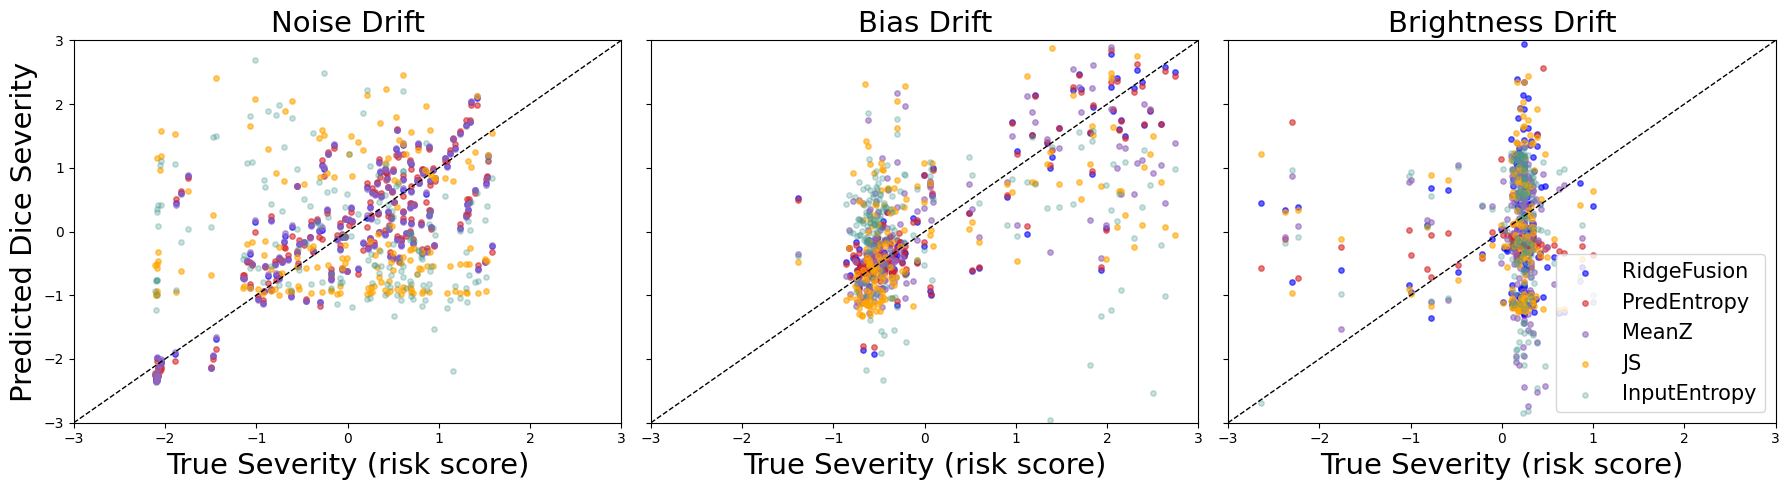

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

TARGET = "sevDice_WT"
drifts = ["noise", "bias", "brightness"]

methods = {
    "RidgeFusion": lambda df: df[f"pred_RidgeFusion_{TARGET}"],
    "PredEntropy": lambda df: df["PredEntropy_tumor_delta"],
    "MeanZ": lambda df: df[f"pred_MeanZ_{TARGET}"],
    "JS": lambda df: df["JS_input_mean"],
    "InputEntropy": lambda df: df["InputEntropy_delta_mean"],
}

colors = {
    "RidgeFusion": "blue",
    "PredEntropy": "tab:red",
    "MeanZ": "tab:purple",
    "JS": "orange",
    "InputEntropy": "#469990",
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, drift in zip(axes, drifts):

    df_drift = pred_store[(drift, TARGET)].copy()

    y_true = df_drift[TARGET].values

    # Normalize all predictions for fair visual comparison
    scaler = StandardScaler()
    y_true_norm = scaler.fit_transform(y_true.reshape(-1,1)).flatten()

    for name, func in methods.items():
        y_pred = func(df_drift).values.reshape(-1,1)
        y_pred_norm = StandardScaler().fit_transform(y_pred).flatten()

        ax.scatter(
            y_true_norm,
            y_pred_norm,
            s=15,
            alpha=0.6 if name!="InputEntropy" else 0.3,
            label=name,
            color=colors[name]
        )

    # reference diagonal
    lims = [-3, 3]
    ax.plot(lims, lims, "k--", linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_title(f"{drift.capitalize()} Drift", fontsize=21)
    ax.set_xlabel("True Severity (risk score)",fontsize=21)

axes[0].set_ylabel("Predicted Dice Severity",fontsize=21)
axes[2].legend(loc="lower right", fontsize=15)

plt.tight_layout()
plt.savefig("synthetic_severity_Dice.png", dpi=500, bbox_inches="tight")
plt.show()


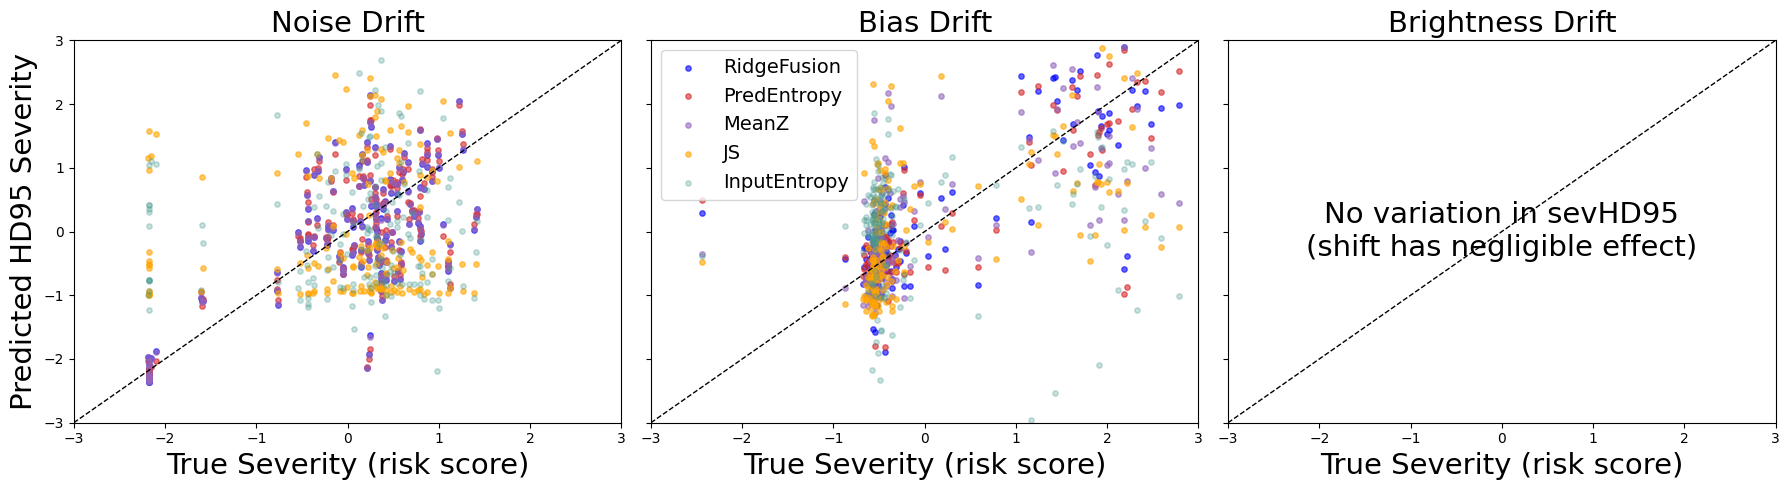

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- HD severity target ---
TARGET = "sevHD95_WT"
drifts = ["noise", "bias", "brightness"]

methods = {
    "RidgeFusion": lambda df: df[f"pred_RidgeFusion_{TARGET}"],
    "PredEntropy": lambda df: df["PredEntropy_tumor_delta"],
    "MeanZ": lambda df: df[f"pred_MeanZ_{TARGET}"],
    "JS": lambda df: df["JS_input_mean"],
    "InputEntropy": lambda df: df["InputEntropy_delta_mean"],
}

colors = {
    "RidgeFusion": "blue",
    "PredEntropy": "tab:red",
    "MeanZ": "tab:purple",
    "JS": "orange",
    "InputEntropy": "#469990",
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, drift in zip(axes, drifts):

    df_drift = pred_store[(drift, TARGET)].copy()

    y_true = df_drift[TARGET].values

    # Handle degenerate cases (brightness often yields constant HD -> correlations NaN)
    if np.allclose(y_true, y_true[0], atol=1e-12):
        ax.set_title(f"{drift.capitalize()} Drift", fontsize=21)
        ax.set_xlabel("True Severity (risk score)", fontsize=21)
        ax.text(
            0.5, 0.5,
            "No variation in sevHD95\n(shift has negligible effect)",
            transform=ax.transAxes,
            ha="center", va="center",
            fontsize=21
        )
        ax.plot([-3, 3], [-3, 3], "k--", linewidth=1)
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        continue

    # Normalize all predictions for fair visual comparison
    scaler = StandardScaler()
    y_true_norm = scaler.fit_transform(y_true.reshape(-1, 1)).flatten()

    for name, func in methods.items():
        y_pred = func(df_drift).values.reshape(-1, 1)

        # If a method output is constant for this drift, avoid StandardScaler producing zeros silently
        if np.allclose(y_pred, y_pred[0], atol=1e-12):
            y_pred_norm = np.zeros_like(y_true_norm)
        else:
            y_pred_norm = StandardScaler().fit_transform(y_pred).flatten()

        ax.scatter(
            y_true_norm,
            y_pred_norm,
            s=15,
            alpha=0.6 if name != "InputEntropy" else 0.3,
            label=name,
            color=colors[name]
        )

    # reference diagonal
    lims = [-3, 3]
    ax.plot(lims, lims, "k--", linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_title(f"{drift.capitalize()} Drift", fontsize=21)
    ax.set_xlabel("True Severity (risk score)", fontsize=21)

axes[0].set_ylabel("Predicted HD95 Severity", fontsize=21)
axes[1].legend(loc="upper left", fontsize=14)

plt.tight_layout()
plt.savefig("synthetic_severity_HD95.png", dpi=500, bbox_inches="tight")
plt.show()


In [ ]:
df["sevDice_WT"] = -df["dDice_WT"]

FEATURES = ["JS_input_mean", "InputEntropy_delta_mean", "PredEntropy_tumor_delta"]
TARGET = "sevDice_WT"  # recommended

drifts = ["brightness", "noise", "bias"]
rows = []
pred_store = {}

for test_drift in drifts:
    train_df = df[df["drift_type"] != test_drift].copy()
    test_df  = df[df["drift_type"] == test_drift].copy()

    y = test_df[TARGET].values

    # Ridge fusion (with alpha tuning)
    model, pred_ridge, best = fit_predict_ridge(train_df, test_df, FEATURES, target=TARGET)
    rows.append({"test_drift": test_drift, "method": "RidgeFusion", "n_test": len(test_df), **best, **eval_regression(y, pred_ridge)})
    pred_store[(test_drift, "RidgeFusion")] = (test_df, pred_ridge)

    # Mean-Z
    pred_meanz = mean_z_score(train_df, test_df, FEATURES)
    rows.append({"test_drift": test_drift, "method": "MeanZ", "n_test": len(test_df), **eval_regression(y, pred_meanz)})
    pred_store[(test_drift, "MeanZ")] = (test_df, pred_meanz)

    # Single-feature baselines
    for feat in FEATURES:
        pred_feat = single_feature_score(train_df, test_df, feat)
        rows.append({"test_drift": test_drift, "method": f"Single:{feat}", "n_test": len(test_df), **eval_regression(y, pred_feat)})
        pred_store[(test_drift, f"Single:{feat}")] = (test_df, pred_feat)

results = pd.DataFrame(rows).sort_values(["test_drift","method"])
results


,test_drift,method,n_test,reg__alpha,RMSE,MAE,Pearson_r,Spearman_rho,Kendall_tau
11,bias,MaxZ,167,NaN,0.729729,0.520051,0.605718,0.621237,0.442320
10,bias,RidgeFusion,167,0.01,0.121207,0.076012,0.876592,0.603943,0.447226
13,bias,Single:InputEntropy_delta_mean,167,NaN,0.974416,0.774474,0.046201,0.158384,0.105981
12,bias,Single:JS_input_mean,167,NaN,0.893107,0.702869,0.522801,0.574443,0.400909
14,bias,Single:PredEntropy_tumor_delta,167,NaN,0.763020,0.707222,0.881309,0.626880,0.464108
1,brightness,MaxZ,168,NaN,1.268174,0.985005,-0.173839,-0.032324,-0.024102
0,brightness,RidgeFusion,168,0.01,0.042134,0.039553,-0.195007,-0.038015,-0.029153
3,brightness,Single:InputEntropy_delta_mean,168,NaN,2.434121,2.112120,0.144750,-0.036545,-0.023813
2,brightness,Single:JS_input_mean,168,NaN,1.439199,1.145844,-0.173839,-0.032324,-0.024102
4,brightness,Single:PredEntropy_tumor_delta,168,NaN,1.140612,1.140606,-0.355966,-0.155056,-0.122028


Missing modality section

/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.

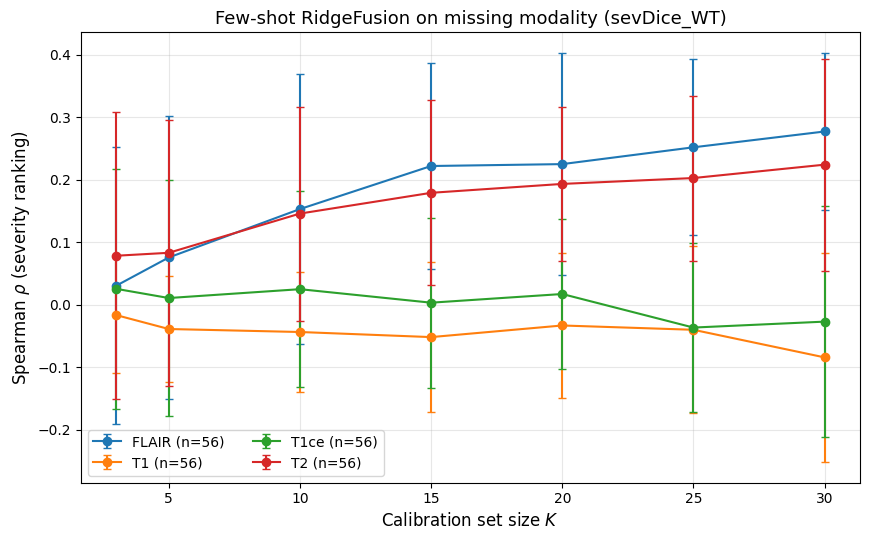

/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.

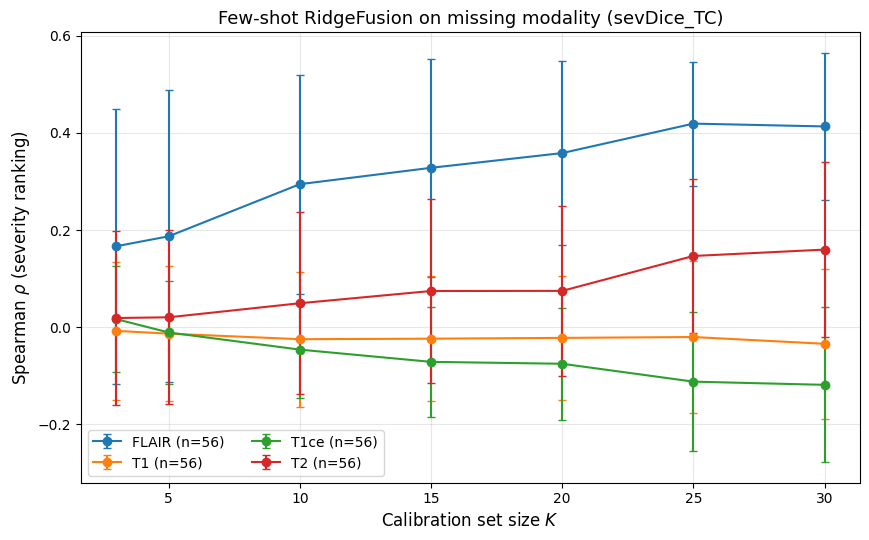

/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.

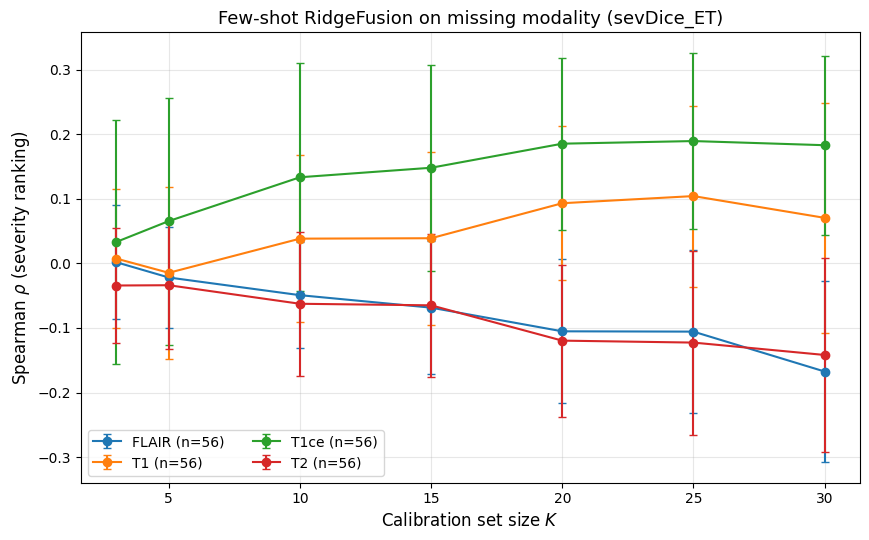

/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.

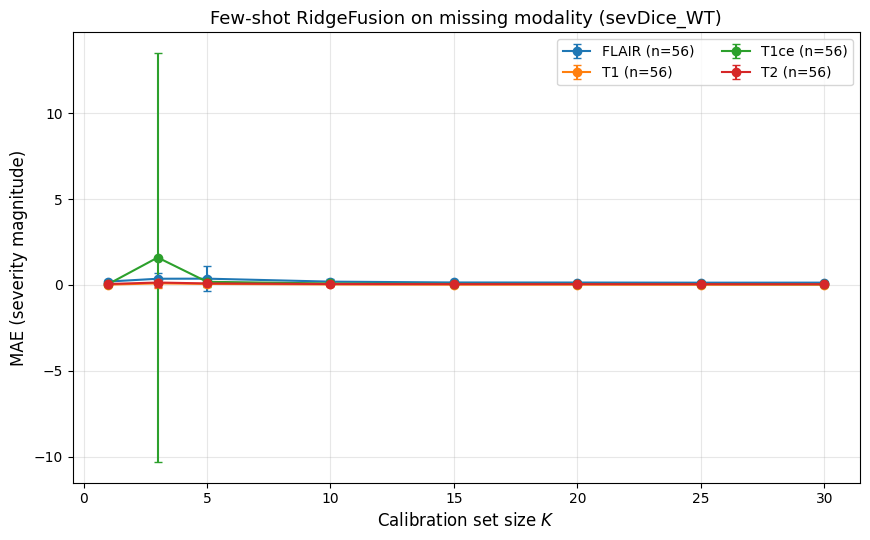

/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.

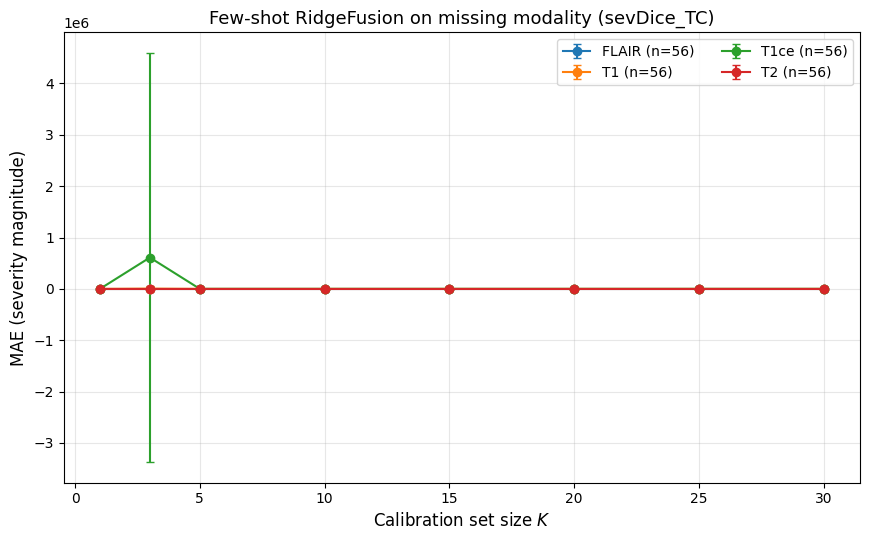

/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-483377506.py:68: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.

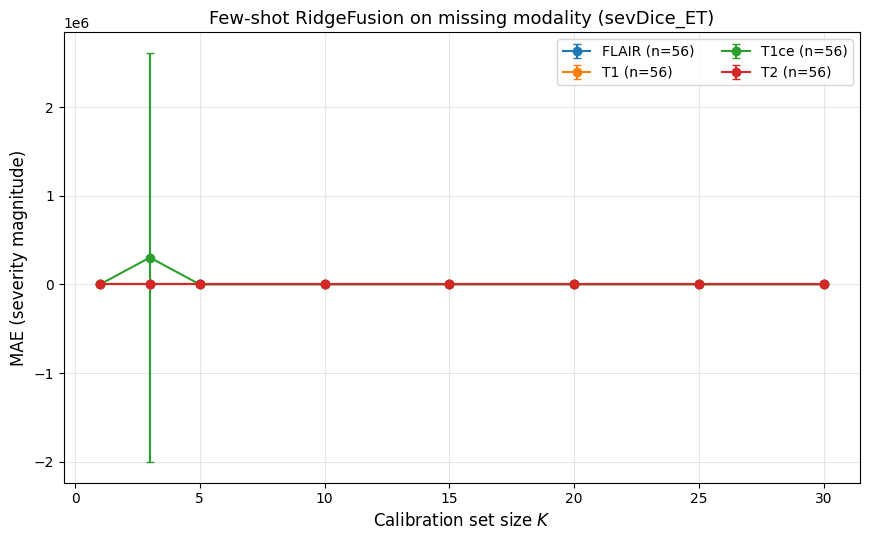

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr

# ----------------------------
# Config
# ----------------------------
BASE = "/content/drive/MyDrive/MEDICAL/InfoTheo_dataset"
F_MISS = os.path.join(BASE, "results_missing_modality_with_entropy_brats2020_test.csv")

FEATURES = ["JS_input_mean", "InputEntropy_delta_mean", "PredEntropy_tumor_delta"]

K_VALUES = [1, 3, 5, 10, 15, 20, 25, 30]
N_REPEATS = 100
RIDGE_ALPHA = 1.0

RNG = np.random.default_rng(1234)

# ----------------------------
# Helpers
# ----------------------------
def safe_spearman(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    if len(y) < 3 or np.std(y) < 1e-12 or np.std(yhat) < 1e-12:
        return np.nan
    return float(spearmanr(y, yhat)[0])

def fit_ridge(train_df, target):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=RIDGE_ALPHA))
    ])
    model.fit(train_df[FEATURES], train_df[target])
    return model

def fewshot_curve(df_mod, target, K_values, n_repeats):
    """
    Returns a DataFrame with mean±std Spearman and MAE for RidgeFusion vs K.
    """
    rows = []
    n = len(df_mod)

    for K in K_values:
        if K >= n - 3:
            continue

        spears, maes = [], []
        for _ in range(n_repeats):
            idx = RNG.permutation(n)
            tr = df_mod.iloc[idx[:K]]
            te = df_mod.iloc[idx[K:]]

            model = fit_ridge(tr, target)
            pred = model.predict(te[FEATURES])

            spears.append(safe_spearman(te[target].values, pred))
            maes.append(mean_absolute_error(te[target].values, pred))

        rows.append({
            "K": K,
            "Spearman_mean": np.nanmean(spears),
            "Spearman_std":  np.nanstd(spears),
            "MAE_mean": np.nanmean(maes),
            "MAE_std":  np.nanstd(maes),
            "n_total": n
        })

    return pd.DataFrame(rows).sort_values("K")


def plot_curves(curves_dict, title, ylabel, y_col, yerr_col, savepath=None, dpi=500):
    plt.figure(figsize=(8.8, 5.5))
    for label, curve in curves_dict.items():
        plt.errorbar(
            curve["K"], curve[y_col],
            yerr=curve[yerr_col],
            marker="o", capsize=3, linewidth=1.5,
            label=label
        )
    plt.xlabel("Calibration set size $K$", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=13)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=10, ncol=2)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()


# ----------------------------
# Load missing-modality data
# ----------------------------
df = pd.read_csv(F_MISS)

df["dDice_TC"] = df["Dice_TC"] - df["Dice_TC_clean"]
df["dDice_ET"] = df["Dice_ET"] - df["Dice_ET_clean"]

# Ensure deltas exist (they should, per your file)
required_cols = ["dDice_WT", "dDice_TC", "dDice_ET", "dHD95_WT", "missing_mod"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

# Define severity targets (positive = worse)
df["sevDice_WT"] = -df["dDice_WT"]
df["sevDice_TC"] = -df["dDice_TC"]
df["sevDice_ET"] = -df["dDice_ET"]

# If wen want HD severity too (WT only here, add TC/ET if we computed them)
df["sevHD95_WT"] = df["dHD95_WT"]

# ----------------------------
# Run curves for WT / TC / ET (Spearman vs K)
# One figure per target to keep it readable
# ----------------------------
TARGETS = ["sevDice_WT", "sevDice_TC", "sevDice_ET"]

for TARGET in TARGETS:
    curves = {}
    for mod in sorted(df["missing_mod"].unique()):
        df_mod = df[df["missing_mod"] == mod].reset_index(drop=True)
        curve = fewshot_curve(df_mod, TARGET, K_VALUES, N_REPEATS)
        curves[f"{mod} (n={len(df_mod)})"] = curve

    out_png = os.path.join(BASE, f"fewshot_ridge_{TARGET}_spearman.png")
    plot_curves(
        curves_dict=curves,
        title=f"Few-shot RidgeFusion on missing modality ({TARGET})",
        ylabel="Spearman $\\rho$ (severity ranking)",
        y_col="Spearman_mean",
        yerr_col="Spearman_std",
        savepath=out_png,
        dpi=500
    )

# ----------------------------
# Optional: if we also want MAE figures for WT / TC / ET
# ----------------------------
for TARGET in TARGETS:
    curves = {}
    for mod in sorted(df["missing_mod"].unique()):
        df_mod = df[df["missing_mod"] == mod].reset_index(drop=True)
        curve = fewshot_curve(df_mod, TARGET, K_VALUES, N_REPEATS)
        curves[f"{mod} (n={len(df_mod)})"] = curve

    out_png = os.path.join(BASE, f"fewshot_ridge_{TARGET}_mae.png")
    plot_curves(
        curves_dict=curves,
        title=f"Few-shot RidgeFusion on missing modality ({TARGET})",
        ylabel="MAE (severity magnitude)",
        y_col="MAE_mean",
        yerr_col="MAE_std",
        savepath=out_png,
        dpi=500
    )


/tmp/ipython-input-301/3388305401.py:64: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-301/3388305401.py:64: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-301/3388305401.py:64: RuntimeWarning: Mean of empty slice
  "Spearman_mean": np.nanmean(spears),
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-301/3388305401.py:64: RuntimeWarning: Mean of empty slice
  

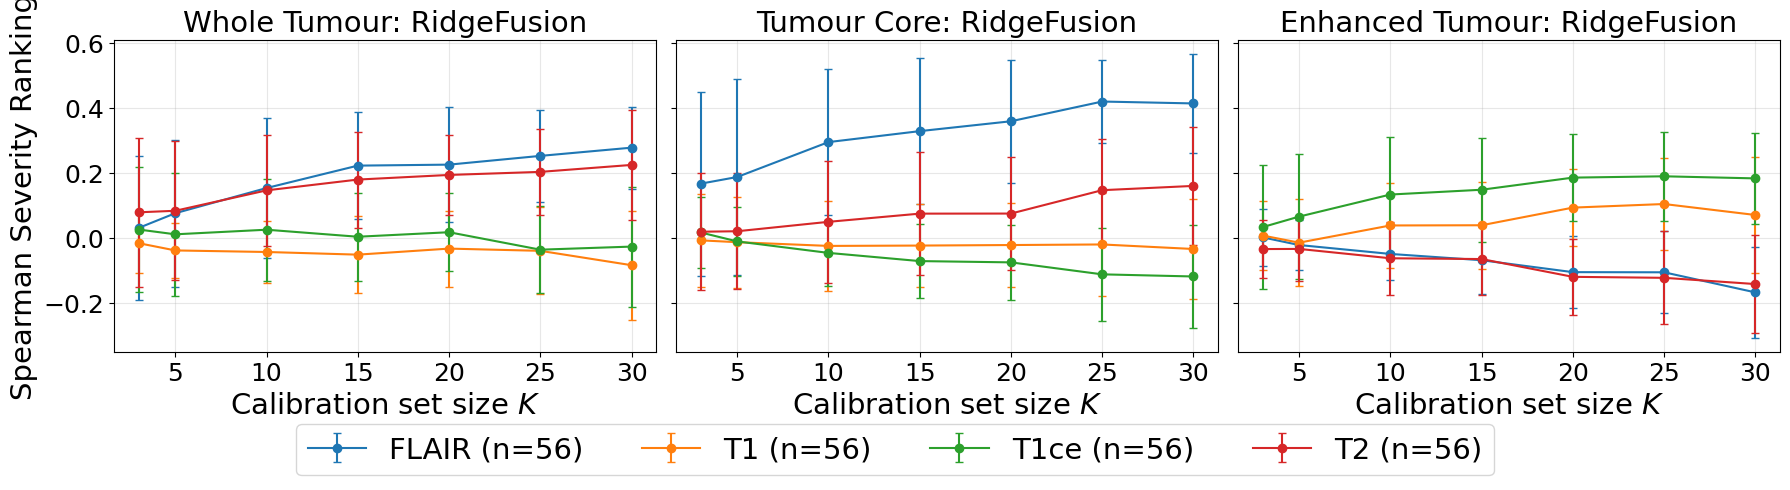

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr

# ----------------------------
# Config
# ----------------------------
BASE = "/content/drive/MyDrive/MEDICAL/InfoTheo_dataset"
F_MISS = os.path.join(BASE, "results_missing_modality_with_entropy_brats2020_test.csv")

FEATURES = ["JS_input_mean", "InputEntropy_delta_mean", "PredEntropy_tumor_delta"]

K_VALUES = [1, 3, 5, 10, 15, 20, 25, 30]
N_REPEATS = 100
RIDGE_ALPHA = 1.0

RNG = np.random.default_rng(1234)

# ----------------------------
# Helpers
# ----------------------------
def safe_spearman(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    if len(y) < 3 or np.std(y) < 1e-12 or np.std(yhat) < 1e-12:
        return np.nan
    return float(spearmanr(y, yhat)[0])

def fit_ridge(train_df, target):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=RIDGE_ALPHA))
    ])
    model.fit(train_df[FEATURES], train_df[target])
    return model

def fewshot_curve(df_mod, target, K_values, n_repeats):
    rows = []
    n = len(df_mod)

    for K in K_values:
        if K >= n - 3:
            continue

        spears = []
        for _ in range(n_repeats):
            idx = RNG.permutation(n)
            tr = df_mod.iloc[idx[:K]]
            te = df_mod.iloc[idx[K:]]

            model = fit_ridge(tr, target)
            pred = model.predict(te[FEATURES])

            spears.append(safe_spearman(te[target].values, pred))

        rows.append({
            "K": K,
            "Spearman_mean": np.nanmean(spears),
            "Spearman_std":  np.nanstd(spears),
            "n_total": n
        })

    return pd.DataFrame(rows).sort_values("K")


# ----------------------------
# Load + compute TC/ET deltas & severities
# ----------------------------
df = pd.read_csv(F_MISS)

df["dDice_TC"] = df["Dice_TC"] - df["Dice_TC_clean"]
df["dDice_ET"] = df["Dice_ET"] - df["Dice_ET_clean"]

df["sevDice_WT"] = -df["dDice_WT"]
df["sevDice_TC"] = -df["dDice_TC"]
df["sevDice_ET"] = -df["dDice_ET"]

TARGETS = [("Whole Tumour", "sevDice_WT"), ("Tumour Core", "sevDice_TC"), ("Enhanced Tumour", "sevDice_ET")]
mods = sorted(df["missing_mod"].unique())

# ----------------------------
# Compute curves for each target + modality
# ----------------------------
curves = {}  # curves[(target_key, missing_mod)] = curve_df

for tkey, tcol in TARGETS:
    for mod in mods:
        df_mod = df[df["missing_mod"] == mod].reset_index(drop=True)
        curves[(tkey, mod)] = fewshot_curve(df_mod, tcol, K_VALUES, N_REPEATS)

# ----------------------------
# Plot: 3 subplots (WT/TC/ET), each showing modality curves
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (tkey, tcol) in zip(axes, TARGETS):

    for mod in mods:
        c = curves[(tkey, mod)]
        n = int(c["n_total"].iloc[0]) if "n_total" in c.columns and len(c) else len(df[df["missing_mod"] == mod])

        ax.errorbar(
            c["K"], c["Spearman_mean"],
            yerr=c["Spearman_std"],
            marker="o", capsize=3, linewidth=1.5,
            label=f"{mod} (n={n})"
        )

    ax.set_title(f"{tkey}: RidgeFusion", fontsize=21)
    ax.set_xlabel("Calibration set size $K$", fontsize=21)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=18)

axes[0].set_ylabel("Spearman Severity Ranking", fontsize=21)

# One legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=21, frameon=True)

plt.tight_layout(rect=[0, 0.12, 1, 1])

# Save high DPI
out_png = os.path.join(BASE, "fewshot_ridge_missingmod_spearman_WT_TC_ET.png")
out_pdf = os.path.join(BASE, "fewshot_ridge_missingmod_spearman_WT_TC_ET.pdf")
plt.savefig(out_png, dpi=500, bbox_inches="tight")
plt.savefig(out_pdf, bbox_inches="tight")

plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

def z(x):
    x = np.asarray(x).reshape(-1,1)
    return StandardScaler().fit_transform(x).ravel()

def eval_metrics_zmse(y, yhat):
    # scale-free MSE (both standardized)
    y_z = z(y)
    yhat_z = z(yhat)
    return {
        "zMSE": float(mean_squared_error(y_z, yhat_z)),
        "Spearman": _safe_corr(spearmanr, y, yhat),
        "Pearson": _safe_corr(pearsonr, y, yhat),
    }

rows = []
for mod in missing_mods:
    df_mod = miss[miss["missing_mod"] == mod].reset_index(drop=True)
    n = len(df_mod)

    if K_FIXED >= n - 3:
        raise ValueError(f"K_FIXED={K_FIXED} too large for {mod}, n={n}")

    # Repeat splits and evaluate *all* methods on the same held-out
    stats = {name: {"dice": [], "hd": []} for name in ["Ridge", "PredEntropy", "MaxZ", "JS", "InputEntropy"]}

    for _ in range(N_REPEATS):
        idx = RNG.permutation(n)
        tr = df_mod.iloc[idx[:K_FIXED]]
        te = df_mod.iloc[idx[K_FIXED:]]

        # targets (held-out only)
        y_dice = te["sevDice_WT"].values
        y_hd   = te["sevHD95_WT"].values

        # Ridge (trained on tr)
        model_d = fit_ridge(tr, "sevDice_WT")
        pred_ridge_d = model_d.predict(te[FEATURES])
        stats["Ridge"]["dice"].append(eval_metrics_zmse(y_dice, pred_ridge_d))

        model_h = fit_ridge(tr, "sevHD95_WT")
        pred_ridge_h = model_h.predict(te[FEATURES])
        stats["Ridge"]["hd"].append(eval_metrics_zmse(y_hd, pred_ridge_h))

        # Baselines (no training, but evaluated on same held-out te)
        pred_pe = te["PredEntropy_tumor_delta"].values
        pred_js = te["JS_input_mean"].values
        pred_ie = te["InputEntropy_delta_mean"].values
        pred_mz = predict_maxz(te, FEATURES, med_ref, iqr_ref)

        stats["PredEntropy"]["dice"].append(eval_metrics_zmse(y_dice, pred_pe))
        stats["PredEntropy"]["hd"].append(eval_metrics_zmse(y_hd, pred_pe))

        stats["JS"]["dice"].append(eval_metrics_zmse(y_dice, pred_js))
        stats["JS"]["hd"].append(eval_metrics_zmse(y_hd, pred_js))

        stats["InputEntropy"]["dice"].append(eval_metrics_zmse(y_dice, pred_ie))
        stats["InputEntropy"]["hd"].append(eval_metrics_zmse(y_hd, pred_ie))

        stats["MaxZ"]["dice"].append(eval_metrics_zmse(y_dice, pred_mz))
        stats["MaxZ"]["hd"].append(eval_metrics_zmse(y_hd, pred_mz))

    # Aggregate mean±std for each method
    def agg(method, split, key):
        vals = np.array([d[key] for d in stats[method][split]], float)
        return float(np.nanmean(vals)), float(np.nanstd(vals))

    method_map = {
        "Ridge": f"Ridge Fusion (K={K_FIXED})",
        "PredEntropy": "Pred Entropy",
        "MaxZ": "Max Z",
        "JS": "JS Divergence",
        "InputEntropy": "Input Entropy"
    }

    for mkey, mname in method_map.items():
        rows.append({
            "Missing Modality": mod,
            "Risk Signal": mname,
            ("zMSE", "Dice"): fmt_mean_std(*agg(mkey, "dice", "zMSE")),
            ("zMSE", "HD95"): fmt_mean_std(*agg(mkey, "hd", "zMSE")),
            ("Spearman $\\rho$", "Dice"): fmt_mean_std(*agg(mkey, "dice", "Spearman")),
            ("Spearman $\\rho$", "HD95"): fmt_mean_std(*agg(mkey, "hd", "Spearman")),
            ("Pearson $r$", "Dice"): fmt_mean_std(*agg(mkey, "dice", "Pearson")),
            ("Pearson $r$", "HD95"): fmt_mean_std(*agg(mkey, "hd", "Pearson")),
            "n": n
        })

table = pd.DataFrame(rows)

NameError: name 'missing_mods' is not defined

In [ ]:
display(table)

,Missing Modality,Risk Signal,"(zMSE, Dice)","(zMSE, HD95)","(Spearman $\rho$, Dice)","(Spearman $\rho$, HD95)","(Pearson $r$, Dice)","(Pearson $r$, HD95)",n
0,FLAIR,Ridge Fusion (K=10),1.4358±0.4830,1.3559±0.4702,0.2024±0.1830,0.2848±0.1903,0.2821±0.2415,0.3220±0.2351,56
1,FLAIR,Pred Entropy,3.0819±0.1129,3.0396±0.1200,-0.3669±0.0577,-0.4526±0.0593,-0.5409±0.0564,-0.5198±0.0600,56
2,FLAIR,Max Z,1.8594±0.1199,1.9665±0.0863,0.0524±0.0615,-0.0984±0.0688,0.0703±0.0600,0.0167±0.0432,56
3,FLAIR,JS Divergence,1.8594±0.1199,1.9665±0.0863,0.0524±0.0615,-0.0984±0.0688,0.0703±0.0600,0.0167±0.0432,56
4,FLAIR,Input Entropy,1.8036±0.1221,1.8304±0.0880,0.0585±0.0587,0.0552±0.0576,0.0982±0.0610,0.0848±0.0440,56
5,T1,Ridge Fusion (K=10),1.9519±0.2734,2.0386±0.1978,-0.0303±0.0849,-0.0513±0.0820,0.0240±0.1367,-0.0193±0.0989,56
6,T1,Pred Entropy,1.5385±0.1434,1.7298±0.1619,0.0639±0.0670,0.0341±0.0696,0.2308±0.0717,0.1351±0.0809,56
7,T1,Max Z,1.8938±0.0747,1.9329±0.0494,-0.1523±0.0673,-0.1019±0.0726,0.0531±0.0373,0.0335±0.0247,56
8,T1,JS Divergence,1.8938±0.0747,1.9329±0.0494,-0.1523±0.0673,-0.1019±0.0726,0.0531±0.0373,0.0335±0.0247,56
9,T1,Input Entropy,1.8471±0.1224,2.1316±0.1495,0.0312±0.0620,-0.0211±0.0646,0.0764±0.0612,-0.0658±0.0748,56


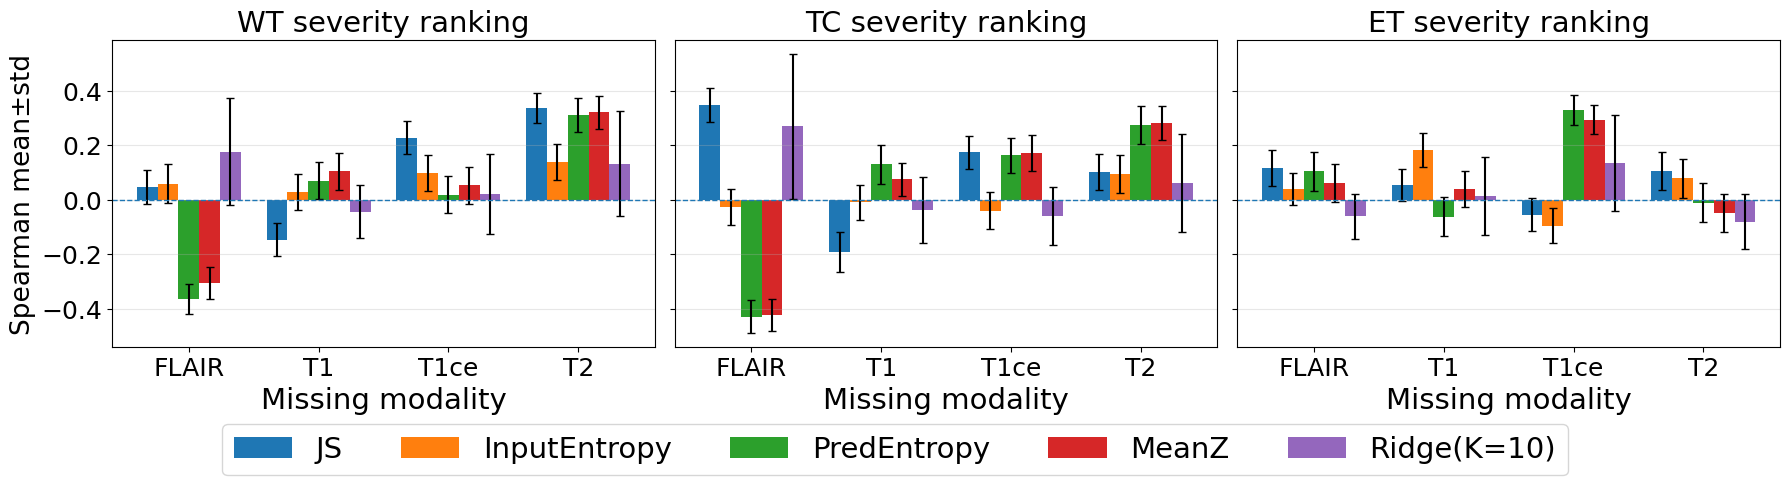

Saved: /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/bar_compare_missingmod_spearman_WT_TC_ET_K10.png
Saved: /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/bar_compare_missingmod_spearman_WT_TC_ET_K10.pdf


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr, pearsonr

# ----------------------------
# CONFIG
# ----------------------------
BASE = "/content/drive/MyDrive/MEDICAL/InfoTheo_dataset"
F_MISS = os.path.join(BASE, "results_missing_modality_with_entropy_brats2020_test.csv")

F_SYN_B = os.path.join(BASE, "results_brightness_with_entropy_brats2020_test.csv")
F_SYN_N = os.path.join(BASE, "results_noise_with_entropy_brats2020_test.csv")
F_SYN_X = os.path.join(BASE, "results_bias_with_entropy_brats2020_test.csv")

FEATURES = ["JS_input_mean", "InputEntropy_delta_mean", "PredEntropy_tumor_delta"]

K_FIXED = 10
N_REPEATS = 200
RIDGE_ALPHA = 1.0
RNG = np.random.default_rng(1234)

# ----------------------------
# Helpers
# ----------------------------
def _safe_corr(fn, y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    if len(y) < 3 or np.std(y) < 1e-12 or np.std(yhat) < 1e-12:
        return np.nan
    return float(fn(y, yhat)[0])

def eval_spearman(y, yhat):
    return _safe_corr(spearmanr, y, yhat)

def fit_ridge(train_df, target):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=RIDGE_ALPHA))
    ])
    model.fit(train_df[FEATURES], train_df[target])
    return model

def fit_ref_stats(df_ref, features):
    med = df_ref[features].median()
    iqr = df_ref[features].quantile(0.75) - df_ref[features].quantile(0.25)
    iqr = iqr.replace(0, 1e-8)
    return med, iqr

def predict_meanz(df, features, med, iqr):
    z = (df[features] - med) / (iqr + 1e-8)
    return z.mean(axis=1).values


# ----------------------------
# Load data
# ----------------------------
miss = pd.read_csv(F_MISS)

# Compute deltas for TC/ET
miss["dDice_TC"] = miss["Dice_TC"] - miss["Dice_TC_clean"]
miss["dDice_ET"] = miss["Dice_ET"] - miss["Dice_ET_clean"]

# Severity targets (positive = worse)
miss["sevDice_WT"] = -miss["dDice_WT"]
miss["sevDice_TC"] = -miss["dDice_TC"]
miss["sevDice_ET"] = -miss["dDice_ET"]

# Synthetic reference for MeanZ
syn_b = pd.read_csv(F_SYN_B); syn_b["drift_type"] = "brightness"
syn_n = pd.read_csv(F_SYN_N); syn_n["drift_type"] = "noise"
syn_x = pd.read_csv(F_SYN_X); syn_x["drift_type"] = "bias"
syn = pd.concat([syn_b, syn_n, syn_x], ignore_index=True)

med_ref, iqr_ref = fit_ref_stats(syn, FEATURES)

missing_mods = sorted(miss["missing_mod"].unique())
targets = [("WT", "sevDice_WT"), ("TC", "sevDice_TC"), ("ET", "sevDice_ET")]

# Methods
methods = [
    ("JS", lambda df: df["JS_input_mean"].values),
    ("InputEntropy", lambda df: df["InputEntropy_delta_mean"].values),
    ("PredEntropy", lambda df: df["PredEntropy_tumor_delta"].values),
    ("MeanZ", lambda df: predict_meanz(df, FEATURES, med_ref, iqr_ref)),
    (f"Ridge(K={K_FIXED})", None),  # handled via few-shot calibration
]

# ----------------------------
# Compute Spearman (mean±std over splits) for each mod/target/method
# ----------------------------
rows = []
for mod in missing_mods:
    df_mod = miss[miss["missing_mod"] == mod].reset_index(drop=True)
    n = len(df_mod)
    if K_FIXED >= n - 3:
        raise ValueError(f"K_FIXED={K_FIXED} too large for {mod} with n={n}")

    for tkey, tcol in targets:
        stats = {name: [] for name, _ in methods}

        for _ in range(N_REPEATS):
            idx = RNG.permutation(n)
            tr = df_mod.iloc[idx[:K_FIXED]]
            te = df_mod.iloc[idx[K_FIXED:]]
            y = te[tcol].values

            # Ridge
            model = fit_ridge(tr, tcol)
            pred_r = model.predict(te[FEATURES])
            stats[f"Ridge(K={K_FIXED})"].append(eval_spearman(y, pred_r))

            # Other signals (same held-out te)
            for name, func in methods:
                if func is None:
                    continue
                pred = func(te)
                stats[name].append(eval_spearman(y, pred))

        for name in stats:
            vals = np.array(stats[name], float)
            rows.append({
                "missing_mod": mod,
                "target": tkey,
                "method": name,
                "Spearman_mean": np.nanmean(vals),
                "Spearman_std": np.nanstd(vals)
            })

bar_df = pd.DataFrame(rows)

# ----------------------------
# Plot: grouped bars, 3 subplots
# ----------------------------
methods_order = ["JS", "InputEntropy", "PredEntropy", "MeanZ", f"Ridge(K={K_FIXED})"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

x = np.arange(len(missing_mods))
bar_width = 0.16

for ax, (tkey, _) in zip(axes, targets):
    sub = bar_df[bar_df["target"] == tkey].copy()

    for i, m in enumerate(methods_order):
        vals = sub[sub["method"] == m].set_index("missing_mod").loc[missing_mods]
        means = vals["Spearman_mean"].values
        stds  = vals["Spearman_std"].values

        ax.bar(
            x + (i - (len(methods_order)-1)/2)*bar_width,
            means,
            width=bar_width,
            yerr=stds,
            capsize=3,
            label=m
        )

    ax.set_xticks(x)
    ax.set_xticklabels(missing_mods)
    ax.set_title(f"{tkey} severity ranking", fontsize=21)
    ax.set_xlabel("Missing modality", fontsize=21)
    ax.grid(axis="y", alpha=0.3)
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.tick_params(axis="both", labelsize=18)

axes[0].set_ylabel("Spearman mean±std", fontsize=19)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=5, fontsize=21, frameon=True)

plt.tight_layout(rect=[0, 0.13, 1, 1])

out_png = os.path.join(BASE, f"bar_compare_missingmod_spearman_WT_TC_ET_K{K_FIXED}.png")
out_pdf = os.path.join(BASE, f"bar_compare_missingmod_spearman_WT_TC_ET_K{K_FIXED}.pdf")
plt.savefig(out_png, dpi=500, bbox_inches="tight")
plt.savefig(out_pdf, bbox_inches="tight")
plt.show()

print("Saved:", out_png)
print("Saved:", out_pdf)

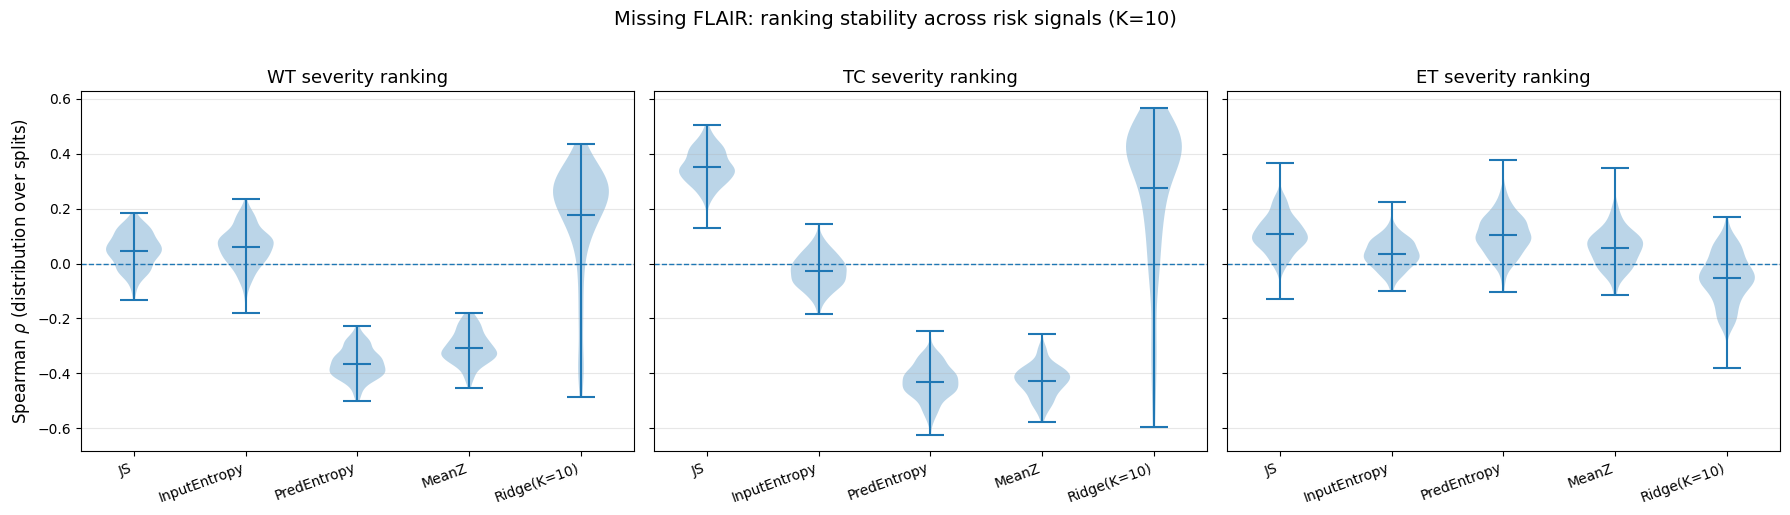

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr

# ----------------------------
# CONFIG (edit if needed)
# ----------------------------
FEATURES = ["JS_input_mean", "InputEntropy_delta_mean", "PredEntropy_tumor_delta"]

K_FIXED = 10
N_REPEATS = 200
RIDGE_ALPHA = 1.0
RNG = np.random.default_rng(1234)

# Choose modality to visualise (change: "T1", "T1ce", "T2", "FLAIR")
CHOSEN_MOD = "FLAIR"

# ----------------------------
# Helpers
# ----------------------------
def safe_spearman(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    if len(y) < 3 or np.std(y) < 1e-12 or np.std(yhat) < 1e-12:
        return np.nan
    return float(spearmanr(y, yhat)[0])

def fit_ridge(train_df, target_col):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=RIDGE_ALPHA))
    ])
    model.fit(train_df[FEATURES], train_df[target_col])
    return model

def fit_ref_stats(df_ref, features):
    med = df_ref[features].median()
    iqr = df_ref[features].quantile(0.75) - df_ref[features].quantile(0.25)
    iqr = iqr.replace(0, 1e-8)
    return med, iqr

def predict_meanz(df, features, med, iqr):
    z = (df[features] - med) / (iqr + 1e-8)
    return z.mean(axis=1).values

# ----------------------------
# Make sure these exist in your session:
# miss, syn_b, syn_n, syn_x (or syn)
# ----------------------------
# If you already created syn and med_ref/iqr_ref in your bar plot code, reuse them.
# Otherwise uncomment and set paths:
#
# BASE = "/content/drive/MyDrive/MEDICAL/InfoTheo_dataset"
# syn_b = pd.read_csv(os.path.join(BASE, "results_brightness_with_entropy_brats2020_test.csv"))
# syn_n = pd.read_csv(os.path.join(BASE, "results_noise_with_entropy_brats2020_test.csv"))
# syn_x = pd.read_csv(os.path.join(BASE, "results_bias_with_entropy_brats2020_test.csv"))
# syn = pd.concat([syn_b, syn_n, syn_x], ignore_index=True)

# Fit MeanZ reference from synthetic pool
med_ref, iqr_ref = fit_ref_stats(syn, FEATURES)

# ----------------------------
# Prepare missing modality subset + targets
# ----------------------------
miss = miss.copy()

# Ensure deltas exist
if "dDice_TC" not in miss.columns:
    miss["dDice_TC"] = miss["Dice_TC"] - miss["Dice_TC_clean"]
if "dDice_ET" not in miss.columns:
    miss["dDice_ET"] = miss["Dice_ET"] - miss["Dice_ET_clean"]

# Severity targets (positive=worse)
miss["sevDice_WT"] = -miss["dDice_WT"]
miss["sevDice_TC"] = -miss["dDice_TC"]
miss["sevDice_ET"] = -miss["dDice_ET"]

df_mod = miss[miss["missing_mod"] == CHOSEN_MOD].reset_index(drop=True)
n = len(df_mod)
if K_FIXED >= n - 3:
    raise ValueError(f"K_FIXED={K_FIXED} too large for {CHOSEN_MOD} with n={n}")

targets = [("WT", "sevDice_WT"), ("TC", "sevDice_TC"), ("ET", "sevDice_ET")]

method_names = ["JS", "InputEntropy", "PredEntropy", "MeanZ", f"Ridge(K={K_FIXED})"]

# ----------------------------
# Collect distributions
# ----------------------------
dists = {tkey: {m: [] for m in method_names} for tkey, _ in targets}

for _ in range(N_REPEATS):
    idx = RNG.permutation(n)
    tr = df_mod.iloc[idx[:K_FIXED]]
    te = df_mod.iloc[idx[K_FIXED:]]

    # Precompute K-independent signals on te
    pred_js = te["JS_input_mean"].values
    pred_ie = te["InputEntropy_delta_mean"].values
    pred_pe = te["PredEntropy_tumor_delta"].values
    pred_mz = predict_meanz(te, FEATURES, med_ref, iqr_ref)

    for tkey, tcol in targets:
        y = te[tcol].values

        # Ridge
        model = fit_ridge(tr, tcol)
        pred_r = model.predict(te[FEATURES])

        dists[tkey]["JS"].append(safe_spearman(y, pred_js))
        dists[tkey]["InputEntropy"].append(safe_spearman(y, pred_ie))
        dists[tkey]["PredEntropy"].append(safe_spearman(y, pred_pe))
        dists[tkey]["MeanZ"].append(safe_spearman(y, pred_mz))
        dists[tkey][f"Ridge(K={K_FIXED})"].append(safe_spearman(y, pred_r))

# ----------------------------
# Plot: 3 violins panels
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (tkey, _) in zip(axes, targets):
    data = [dists[tkey][m] for m in method_names]
    parts = ax.violinplot(data, showmeans=True)

    ax.set_xticks(np.arange(1, len(method_names) + 1))
    ax.set_xticklabels(method_names, rotation=20, ha="right")
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_title(f"{tkey} severity ranking", fontsize=13)
    ax.grid(axis="y", alpha=0.3)

axes[0].set_ylabel("Spearman $\\rho$ (distribution over splits)", fontsize=12)

plt.suptitle(f"Missing {CHOSEN_MOD}: ranking stability across risk signals (K={K_FIXED})", fontsize=14, y=1.02)
plt.tight_layout()

plt.savefig(f"violin_missing_{CHOSEN_MOD}_WT_TC_ET_K{K_FIXED}.png", dpi=500, bbox_inches="tight")
plt.show()

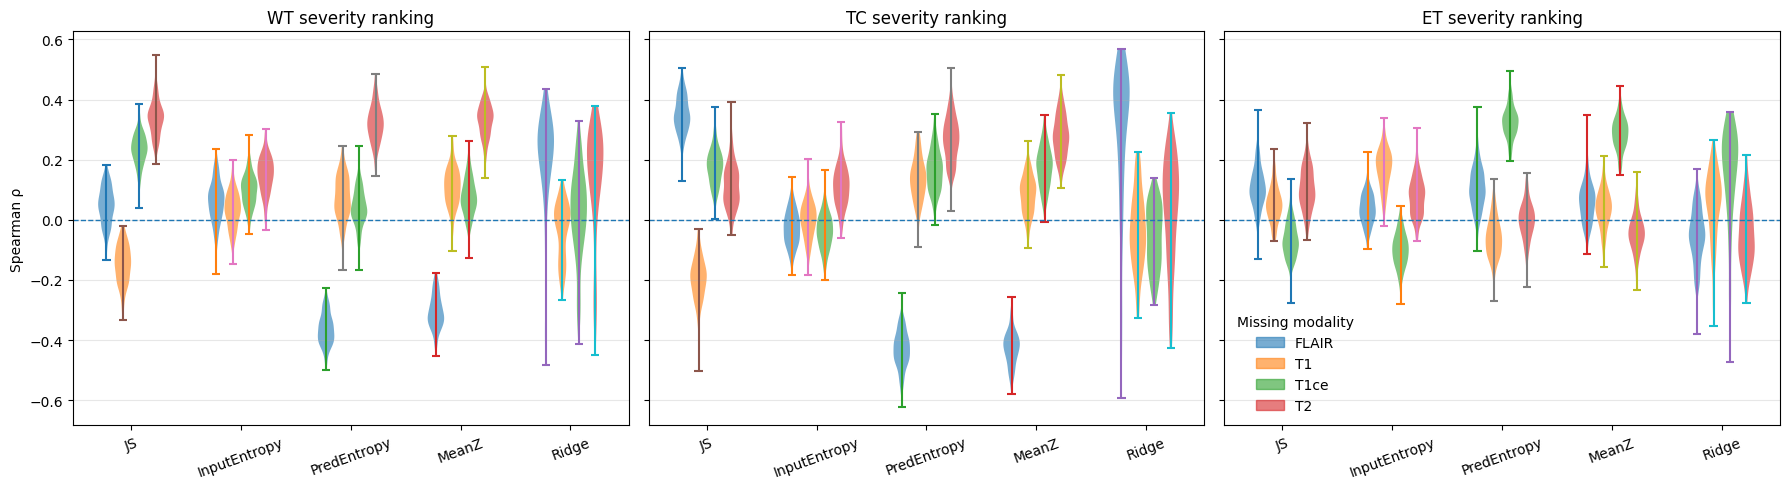

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr

FEATURES = ["JS_input_mean", "InputEntropy_delta_mean", "PredEntropy_tumor_delta"]
K_FIXED = 10
N_REPEATS = 200
RIDGE_ALPHA = 1.0
RNG = np.random.default_rng(1234)

def safe_spearman(y, yhat):
    if len(y) < 3 or np.std(y) < 1e-12 or np.std(yhat) < 1e-12:
        return np.nan
    return spearmanr(y, yhat)[0]

def fit_ridge(train_df, target):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=RIDGE_ALPHA))
    ])
    model.fit(train_df[FEATURES], train_df[target])
    return model

def predict_meanz(df, features, med, iqr):
    z = (df[features] - med) / (iqr + 1e-8)
    return z.mean(axis=1).values

missing_modalities = ["FLAIR", "T1", "T1ce", "T2"]
targets = [("WT","sevDice_WT"),
           ("TC","sevDice_TC"),
           ("ET","sevDice_ET")]

method_names = ["JS","InputEntropy","PredEntropy","MeanZ","Ridge"]

# Storage
results = {
    tkey: {mod: {m: [] for m in method_names}
           for mod in missing_modalities}
    for tkey,_ in targets
}

# Collect distributions
for mod in missing_modalities:
    df_mod = miss[miss["missing_mod"] == mod].reset_index(drop=True)
    n = len(df_mod)

    for _ in range(N_REPEATS):
        idx = RNG.permutation(n)
        tr = df_mod.iloc[idx[:K_FIXED]]
        te = df_mod.iloc[idx[K_FIXED:]]

        pred_js = te["JS_input_mean"].values
        pred_ie = te["InputEntropy_delta_mean"].values
        pred_pe = te["PredEntropy_tumor_delta"].values
        pred_mz = predict_meanz(te, FEATURES, med_ref, iqr_ref)

        for tkey,tcol in targets:
            y = te[tcol].values

            model = fit_ridge(tr, tcol)
            pred_r = model.predict(te[FEATURES])

            results[tkey][mod]["JS"].append(safe_spearman(y,pred_js))
            results[tkey][mod]["InputEntropy"].append(safe_spearman(y,pred_ie))
            results[tkey][mod]["PredEntropy"].append(safe_spearman(y,pred_pe))
            results[tkey][mod]["MeanZ"].append(safe_spearman(y,pred_mz))
            results[tkey][mod]["Ridge"].append(safe_spearman(y,pred_r))

# -----------------------
# Plot
# -----------------------
fig, axes = plt.subplots(1,3, figsize=(18,5), sharey=True)

colors = plt.cm.tab10.colors  # default palette

for ax, (tkey,_) in zip(axes, targets):

    x_base = np.arange(len(method_names))
    width = 0.15

    for i, mod in enumerate(missing_modalities):
        offset = (i - 1.5)*width
        for j, method in enumerate(method_names):
            data = results[tkey][mod][method]
            vp = ax.violinplot(data,
                               positions=[x_base[j]+offset],
                               widths=width,
                               showmeans=False)
            for body in vp['bodies']:
                body.set_facecolor(colors[i])
                body.set_alpha(0.6)

    ax.set_xticks(x_base)
    ax.set_xticklabels(method_names, rotation=20)
    ax.set_title(f"{tkey} severity ranking")
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.grid(axis="y", alpha=0.3)

axes[0].set_ylabel("Spearman ρ")

import matplotlib.patches as mpatches

legend_handles = []
for i, mod in enumerate(missing_modalities):
    patch = mpatches.Patch(
        color=colors[i],
        label=mod,
        alpha=0.6
    )
    legend_handles.append(patch)

axes[2].legend(
    handles=legend_handles,
    title="Missing modality",
    loc="lower left",
    frameon=False
)

plt.tight_layout()
plt.savefig("violin_grouped_missing_modalities.png", dpi=500, bbox_inches="tight")
plt.show()

In [ ]:
out_csv = os.path.join(BASE, f"missing_modality_results_K{K_FIXED}.csv")
table.to_csv(out_csv, index=False)
print(f"Saved to: {out_csv}")

Saved to: /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/missing_modality_results_K10.csv


Starting here again to try to save the drift_metrics_brats2020_test_with_entropy.csv

In [ ]:
import os
import numpy as np
import pandas as pd

BASE = "/content/drive/MyDrive/MEDICAL/InfoTheo_dataset"

f_clean = os.path.join(BASE, "baseline_metrics_brats2020_test.csv")
f_b = os.path.join(BASE, "results_brightness_with_entropy_brats2020_test.csv")
f_n = os.path.join(BASE, "results_noise_with_entropy_brats2020_test.csv")
f_x = os.path.join(BASE, "results_bias_with_entropy_brats2020_test.csv")

for p in [f_clean, f_b, f_n, f_x]:
    assert os.path.exists(p), f"Missing file: {p}"

clean = pd.read_csv(f_clean)
b = pd.read_csv(f_b)
n = pd.read_csv(f_n)
x = pd.read_csv(f_x)

# --- Ensure drift labels ---
b["drift_type"] = "brightness"
n["drift_type"] = "noise"
x["drift_type"] = "bias"

# --- Combine drift frames ---
drift = pd.concat([b, n, x], ignore_index=True)

# --- Basic column sanity checks (fail early, not silently) ---
required_clean = {"case_id","Dice_WT","Dice_TC","Dice_ET","HD95_WT"}
required_drift = {"case_id","Dice_WT","Dice_TC","Dice_ET","HD95_WT","drift_type"}

missing_clean = required_clean - set(clean.columns)
missing_drift = required_drift - set(drift.columns)
assert not missing_clean, f"Clean CSV missing columns: {missing_clean}"
assert not missing_drift, f"Drift CSV missing columns: {missing_drift}"

# --- Merge clean metrics into drift table by case_id ---
clean_ren = clean.rename(columns={
    "Dice_WT": "Dice_WT_clean",
    "Dice_TC": "Dice_TC_clean",
    "Dice_ET": "Dice_ET_clean",
    "HD95_WT": "HD95_WT_clean"
})

# If there are duplicate case_ids in clean, keep first (shouldn't happen, but protects you)
clean_ren = clean_ren.drop_duplicates(subset=["case_id"])

df = drift.merge(clean_ren, on="case_id", how="inner")

# --- Targets: degradation relative to clean ---
df["dDice_WT"] = df["Dice_WT"] - df["Dice_WT_clean"]
df["dHD95_WT"] = df["HD95_WT"] - df["HD95_WT_clean"]

print("Merged regression dataset:", df.shape)

# quick diagnostics
print("Unique case_ids in clean:", clean_ren["case_id"].nunique())
print("Unique case_ids in drift:", drift["case_id"].nunique())
print("Unique case_ids after merge:", df["case_id"].nunique())
print("Rows per drift type:")
print(df["drift_type"].value_counts())

df[[
    "case_id","drift_type",
    "Dice_WT_clean","Dice_WT","dDice_WT",
    "HD95_WT_clean","HD95_WT","dHD95_WT"
]].head()


Merged regression dataset: (504, 37)
Unique case_ids in clean: 56
Unique case_ids in drift: 56
Unique case_ids after merge: 56
Rows per drift type:
drift_type
brightness    168
noise         168
bias          168
Name: count, dtype: int64


,case_id,drift_type,Dice_WT_clean,Dice_WT,dDice_WT,HD95_WT_clean,HD95_WT,dHD95_WT
0,BraTS20_Training_053,brightness,0.955168,0.955168,0.000000e+00,1.414214,1.414214,0.0
1,BraTS20_Training_292,brightness,0.924839,0.924839,0.000000e+00,3.605551,3.605551,0.0
2,BraTS20_Training_369,brightness,0.958735,0.958738,2.341931e-06,2.236068,2.236068,0.0
3,BraTS20_Training_100,brightness,0.961227,0.961227,-2.881926e-07,1.414214,1.414214,0.0
4,BraTS20_Training_276,brightness,0.935782,0.935782,0.000000e+00,6.082763,6.082763,0.0
